# TP1 : Proximal denoising

##### Nathan Lichtle - Alain Riou - Robin San Roman

$%useful latex commands$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\argmin}[1]{\underset{#1}{\arg \min}\;}$
$\newcommand{\argmax}[1]{\underset{#1}{\arg \max}\;}$
$\newcommand{\prox}{\textrm{prox}}$
$\newcommand{\(}{\left(}$
$\newcommand{\)}{\right)}$
To denoise an image, one can seek for a solution to the following optimization problem :
$$\begin{equation}
\min \limits_{x \in \RR^N} \frac{1}{2}\|x-y \|^2 + f(Lx) \tag{1} \label{eq}
\end{equation}$$

where $y \in \mathbb{R}^N$ is the vector corresponding to the observed image which is corrupted by noise, $L \in \mathbb{R}^{N \times N}$ is a suited orthogonal transform, and $f$ is a separable penalty function of the form:
$$(\forall u = (u_i)_{1 \leq i \leq N} \in \RR^N) \
f(u) = \sum \limits_{i = 1}^N f_i (u_i)$$
where $(\forall i \in \{1, \dots, N \}), \ f_i \in \Gamma_0(\RR)$.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import pywt

1. Show that this problem amounts to calculate the proximity operator of a function in $\Gamma_0(\RR^N)$.

$f \circ L$ is convex and lower-semi continuous. Hence $f \circ L \in \Gamma_0(\RR^N)$.

$$\begin{aligned}
\prox_{f \circ L}(y)
&= \argmin{x \in \RR^N} (f \circ L)(x) + \frac{1}{2}\|x-y\|^2 \\
&= \argmin{x \in \RR^N} \frac{1}{2}\|x-y\|^2 + f(Lx)
\end{aligned}$$

2. Check that this is also equivalent to calculate $L^{-1} \prox_f(Ly)$.

$$\begin{aligned}
L^{-1} \prox_f(Ly)
&= L^{-1} \( \argmin{x \in \RR^N} \frac{1}{2}\|x - Ly\|^2 + f(x) \) \\
&= L^{-1} \( \argmin{Lx \in \RR^N} \frac{1}{2}\|Lx - Ly\|^2 + f(Lx) \) \text{ as } L \text{ is a bijective mapping from } \RR^N \text{ to } \RR^N \\
&= L^{-1} \( \argmin{Lx \in \RR^N} \frac{1}{2}\|x - y\|^2 + f(Lx) \) \text{ as } L \text{ is orthogonal} \\
&= \argmin{x \in \RR^N} \frac{1}{2}\|x-y\|^2 + f(Lx)
\end{aligned}$$

3. Download the $\textsf{florence.jpg}$ image. Add to this image a white Gaussian noise with zero-mean and standard deviation equal to 30.

In [2]:
!wget -nc --user ECP --password Optim http://www-syscom.univ-mlv.fr/~chouzeno/ECP/Slides/florence.jpg

Fichier «florence.jpg» déjà présent ; pas de récupération.



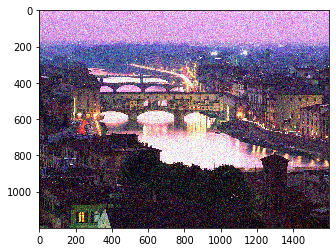

In [3]:
img = plt.imread('florence.jpg')

mean = 0
sigma = 30
noise = np.random.normal(mean, sigma, img.shape)

noised_img = np.clip(img + noise, 0, 255).astype(np.uint8)
plt.imshow(noised_img)
plt.show()

4. Compute the minimizer of $(1)$ when L is a 2D orthonormal wavelet decomposition. Recall that such a decomposition generates a set of so-called approximation coefficients and sets of detail coefficients defined at different resolutions.

Consider the case when
$$(\forall i \in \{1, \dots, n\}) \
f_i =
\begin{cases}
0 \text{ si } i \in \mathbb{K} \\
\varphi \text{ sinon}
\end{cases}$$
where $\mathbb{K}$ is the index set of approximation coefficients, $\varphi = \chi| \bullet |^q$ with $q \in
\{1, 4/3, 3/2, 2, 3, 4\}$, and $\chi \in ]0, +\infty[$ is a constant whose choice will be made
in order to minimize the mean square estimation error.

In [4]:
def prox_x(x, q, Xi):
    '''
    returns prox_f(x), where f(x) = Xi|x|^q
    '''
    if q == '1':
        return np.sign(x) * np.maximum(np.abs(x)-Xi, 0)

    if q == '2':
        return x/(2*Xi+1)

    if q == '4/3':
        eps = np.sqrt(x**2 + 256*Xi**3/729)
        return x + (4*Xi/(3*2**(1/3))) * ((eps-x)**(1/3) - (eps + x)**(1/3))

    if q == '3/2':
        return x + 9*Xi**2*np.sign(x) * (1 - np.sqrt(1 + 16*abs(x)/(9*Xi**2)))/8

    if q == '3': 
        return np.sign(x) * (np.sqrt(1+12*Xi*np.abs(x)) - 1) / (6*Xi)

    if q == '4':
        eps = np.sqrt(x**2 + 1/(27*Xi))
        return ((eps+x)/(8*Xi))**(1/3) - ((eps-x)/(8*Xi))**(1/3)

    raise ValueError('q must be in {1, 4/3, 3/2, 2, 3, 4}. Found q = %d.' % q)

In [5]:
def denoise(noised_img, wave, q, Xi):
    prox = lambda x: prox_x(x, q, Xi)

    Ly = pywt.wavedec2(noised_img, wave, 1, axes=(0,1))
    pLy = [Ly[0]] + [(prox(cHi), prox(cVi), prox(cDi)) for cHi, cVi, cDi in Ly[1:]]
    return pywt.waverec2(pLy, wave, 1, axes=(0,1))

In [6]:
def plot_images(img, noised_img, denoised_img, wave, q, Xi):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,12))
    ax1.imshow(img)
    ax1.set_title('Original')
    ax2.imshow(np.clip(denoised_img,0,255).astype(np.uint8))
    ax2.set_title('Denoised (wave=%s, q=%s, Xi=%.1f)' % (wave, q, Xi))
    ax3.imshow(noised_img)
    ax3.set_title('Noised')

In [8]:
# Executing this cell denoises the noised image with different hyperparameters and saves each result
# in a directory named `denoised_images`

def form(q):
    if q == '4/3':
        return '4-3'
    if q == '3/2':
        return '3-2'
    return q

start = time.time()
os.makedirs('denoised_images', exist_ok=True)
for wave in ['db8','haar']:
    for q in ['1', '4/3', '3/2', '2', '3', '4']:
        for Xi in [0.2, 0.5, 1, 2, 5, 10]:
            print('Processing...\twave = %s\tq = %s\tXi=%.1f   ' % (wave, q, Xi), end='\r')
            denoised_img = denoise(noised_img, wave, q, Xi)
            plt.imsave('denoised_images/%s_q%s_Xi%.1f.jpg' % (wave, form(q), Xi), np.clip(denoised_img, 0, 255).astype(np.uint8))
            
end = time.time()
print('Done. Time elapsed: %.3fs                                   ' % (end-start))

Done. Time elapsed: 109.454s                                   


Changing hyperparameters enables to change to what extent the image is denoised. However, the more it is denoised the more it becomes blurry.
A good balance has to be found to in order to recompute a new image which is detailed enough, without too much noise.

Such a good balance seems to be obtained with the following parameters:

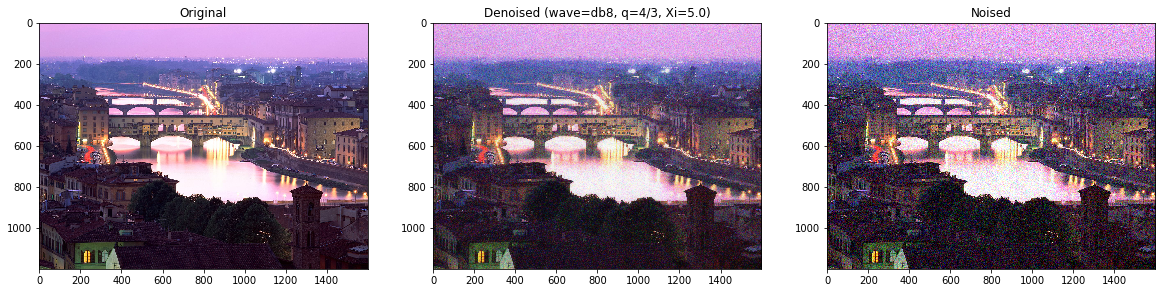

In [9]:
wave = 'db8'
q = '4/3'
Xi = 5

denoised_img = denoise(noised_img, wave, q, Xi)
plot_images(img, noised_img, denoised_img, wave, q, Xi)